In [1]:
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import processing
from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, omnipool_arbitrage, constant_swaps, invest_all
from model.amm.global_state import GlobalState, historical_prices
from model.plot_utils import color_gradient

price_list = processing.import_binance_prices(
    assets = ['DOT'],
    start_date = 'nov 7th, 2022',
    days = 1
)[::12]

# same seed, same parameters = same simulation result
random.seed(42)

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA': 1000},
                'USD': {'liquidity': 10000, 'LRNA': 1000},
                'DOT': {'liquidity': 10000 / price_list[0]['DOT'], 'LRNA': 1000}
            },
            lrna_fee=DynamicFee(
                amplification=1,
                decay=0.0001,
                minimum=0.0005,
                maximum=0.1
            ),
            asset_fee=DynamicFee(
                amplification=1,
                decay=0.0001,
                minimum=0.0025,
                maximum=0.1
            ),
            # asset_fee=0,
            # lrna_fee=0,
            lp_lrna_share=0,
            withdrawal_fee=False
        )
    },
    agents = {
        'LP': Agent(
            holdings={'DOT': 1000},
            trade_strategy=invest_all('omnipool')
        ),
        'Arbitrageur': Agent(
            holdings={'HDX': 100000000, 'USD': 1000000, 'DOT': 100000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
            )
        )
    },
    external_market={'USD': 1, 'HDX': 0.01},
    evolve_function=historical_prices(price_list)
)

In [2]:
low = 0.1
high = 10
spread = 21
price_paths = [low * (high / low) ** (i / (spread - 1)) for i in range(spread)]

In [18]:
no_lp_lrna_events = []
lrna_share_events = []
for price_factor in price_paths:
    price_history_this_run = [
        {tkn: price_list[i][tkn] * (1 - i / len(price_list) + price_factor * i / len(price_list)) for tkn in price_list[i]} 
        for i in range(len(price_list))
    ]
    # give it a period of stability so things can settle out
    price_history_this_run += [price_history_this_run[-1]] * 2000
    initial_state.evolve_function = historical_prices(price_history_this_run)
    initial_state.pools['omnipool'].lp_lrna_share = 0
    no_lp_lrna_events.append(run.run(initial_state, len(price_history_this_run) - 1))
    initial_state.pools['omnipool'].lp_lrna_share = 0.5
    lrna_share_events.append(run.run(initial_state, len(price_history_this_run) - 1))

Starting simulation...
Execution time: 1.085 seconds.
Starting simulation...
Execution time: 1.063 seconds.
Starting simulation...
Execution time: 1.255 seconds.
Starting simulation...
Execution time: 1.104 seconds.
Starting simulation...
Execution time: 1.449 seconds.
Starting simulation...
Execution time: 1.078 seconds.
Starting simulation...
Execution time: 1.006 seconds.
Starting simulation...
Execution time: 1.472 seconds.
Starting simulation...
Execution time: 1.092 seconds.
Starting simulation...
Execution time: 1.041 seconds.
Starting simulation...
Execution time: 1.413 seconds.
Starting simulation...
Execution time: 1.042 seconds.
Starting simulation...
Execution time: 1.152 seconds.
Starting simulation...
Execution time: 1.174 seconds.
Starting simulation...
Execution time: 1.629 seconds.
Starting simulation...
Execution time: 1.149 seconds.
Starting simulation...
Execution time: 1.461 seconds.
Starting simulation...
Execution time: 1.574 seconds.
Starting simulation...
Execu

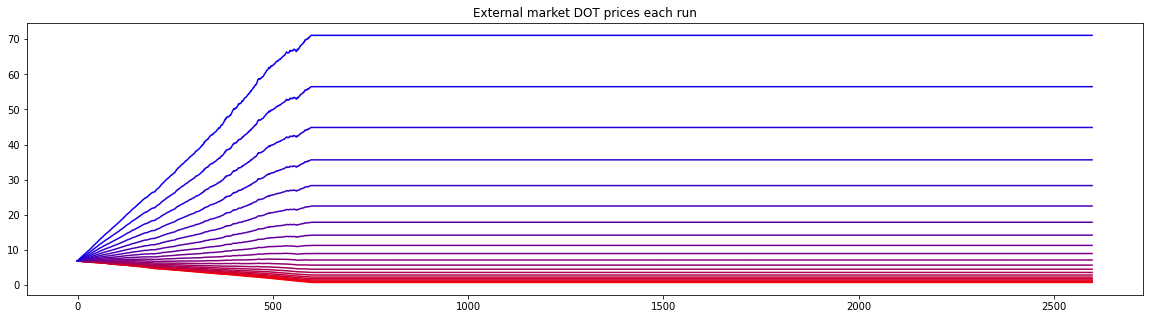

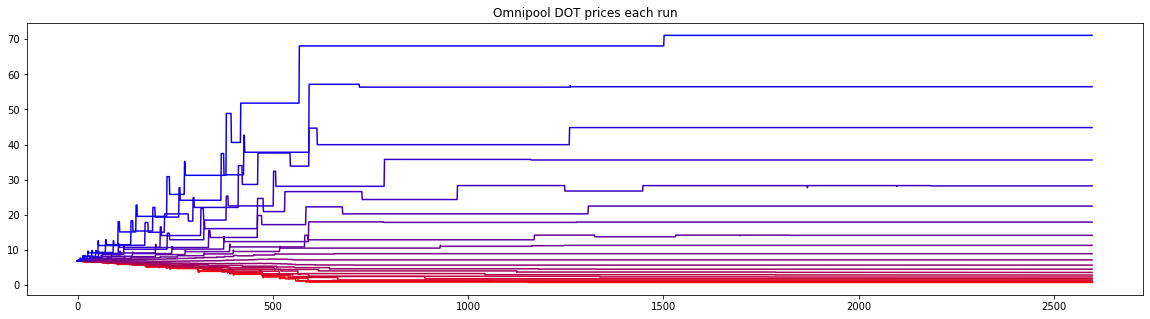

In [19]:
plt.figure(figsize=(20, 5))
# plt.yscale('log')
colors = color_gradient(len(price_paths))
for i, events in enumerate(lrna_share_events):
    plt.plot([event.external_market['DOT'] for event in events], color=colors[i])
plt.title ('External market DOT prices each run')
plt.show()

plt.figure(figsize=(20, 5))
colors = color_gradient(len(price_paths))
for i, events in enumerate(lrna_share_events):
    plt.plot([event.pools['omnipool'].usd_price('DOT') for event in events], color=colors[i])
plt.title('Omnipool DOT prices each run')
plt.show()

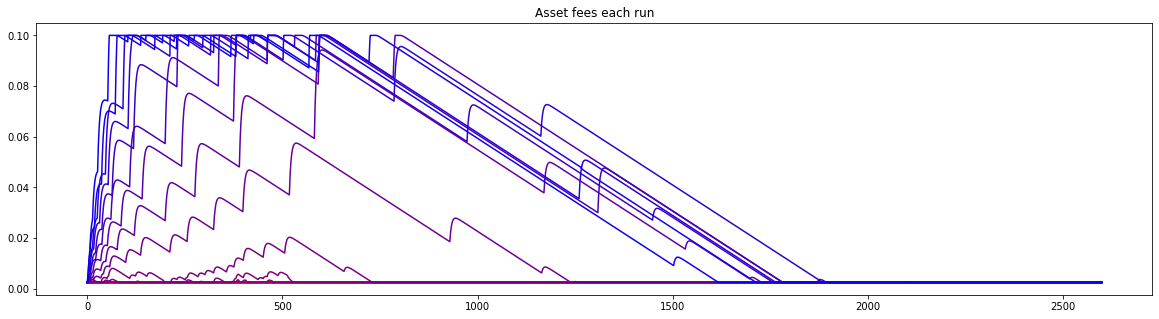

In [20]:
plt.figure(figsize=(20, 5))
colors = color_gradient(len(price_paths))
for i, events in enumerate(lrna_share_events):
    plt.plot([event.pools['omnipool'].last_fee['DOT'] for event in events], color=colors[i])
plt.title('Asset fees each run')
plt.show()

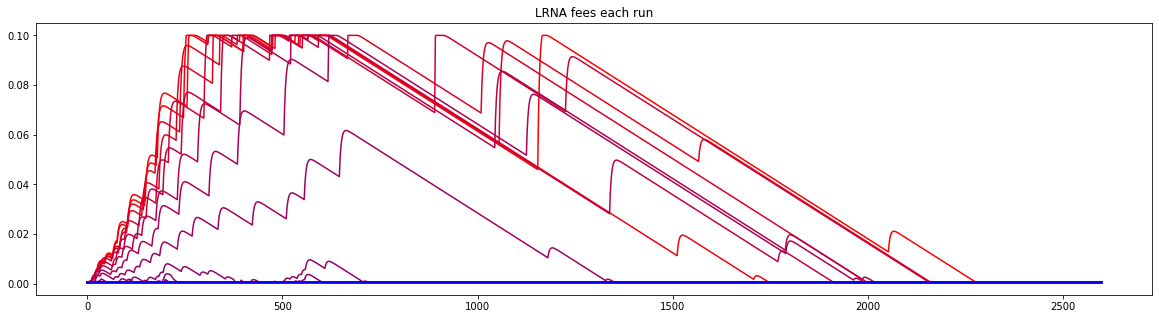

In [21]:
plt.figure(figsize=(20, 5))
colors = color_gradient(len(price_paths))
for i, events in enumerate(lrna_share_events):
    plt.plot([event.pools['omnipool'].last_lrna_fee['DOT'] for event in events], color=colors[i])
plt.title('LRNA fees each run')
plt.show()

In [22]:
# plt.figure(figsize=(20, 5))
# colors = color_gradient(len(price_paths))
# for i, events in enumerate(lrna_share_events):
#     plt.plot([event.pools['omnipool'].cash_out(event.agents['LP'], event.external_market) for event in events], color=colors[i])
# colors = color_gradient(len(price_paths), (255, 255, 0), (128, 0, 255))
# for i, events in enumerate(no_lp_lrna_events):
#     plt.plot([event.pools['omnipool'].cash_out(event.agents['LP'], event.external_market) for event in events], color=colors[i])


In [23]:
case1 = lrna_share_events[0][-1]
case2 = no_lp_lrna_events[0][-1]
print(case1.pools['omnipool'].cash_out(case1.agents['LP'], case1.external_market))
print(case2.pools['omnipool'].cash_out(case2.agents['LP'], case2.external_market))

535.0814224372612
521.7828982720597


In [24]:
print(lrna_share_events[0][0].pools['omnipool'].lp_lrna_share)

0.5


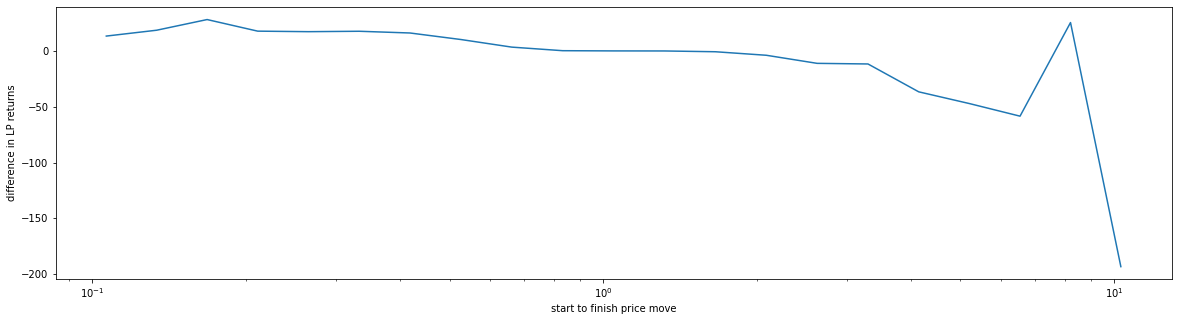

In [26]:
price_move = [events[-1].external_market['DOT'] / events[0].external_market['DOT'] for events in lrna_share_events]
lp_gains = [
    lrna_share_events[i][-1].pools['omnipool'].cash_out(lrna_share_events[i][-1].agents['LP'], lrna_share_events[i][-1].external_market)
    - no_lp_lrna_events[i][-1].pools['omnipool'].cash_out(no_lp_lrna_events[i][-1].agents['LP'], no_lp_lrna_events[i][-1].external_market)
    for i in range(len(lrna_share_events))
]
plt.figure(figsize=(20, 5))
# plt.yscale('log')
plt.xscale('log')
plt.plot(price_move[:len(lp_gains)], lp_gains)
plt.xlabel('start to finish price move')
plt.ylabel('difference in LP returns')
plt.show()